In [1]:
import numpy as np
import gseapy
from scipy.sparse import csr_matrix
from tqdm.contrib.concurrent import process_map
from functools import partial
from scipy.sparse.csgraph import shortest_path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx

path_to_abca7 = '/home/gridsan/djuna/homer/github/ABCA7lof2'
import sys
sys.path.append(path_to_abca7)

from ABCA7lof2.geneclusters import get_scores, get_kernighan_lin_clusters, get_gene_pathway_matrix, get_full_matrix_from_bipartite, plot_component, plot_edges, plot_nodes, group, compute_groupped_matrix, get_scores, find_similar_clusters, get_representative_name_per_cluster, get_kernighan_lin_clusters, get_gene_pathway_matrix, compute_groupped_matrix, get_full_matrix_from_bipartite

In [3]:
frame = pd.read_csv('../supplementary_tables/data_s8.csv')

unique_clusters = np.unique(frame['cluster'])
cm = plt.cm.get_cmap('tab20')
colors = [cm(int(x)) for x in range(len(unique_clusters))]

/state/partition1/slurm_tmp/24515193.0.0/ipykernel_36406/3859499087.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('tab20')


/state/partition1/slurm_tmp/24515193.0.0/ipykernel_36406/1020619114.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')


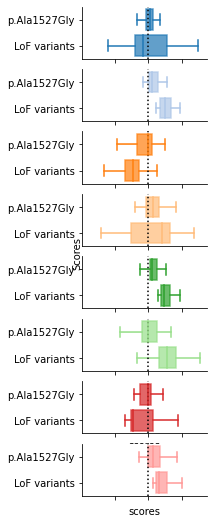

<Figure size 72x360 with 0 Axes>

<Figure size 72x360 with 0 Axes>

<Figure size 72x360 with 0 Axes>

<Figure size 72x360 with 0 Axes>

<Figure size 72x360 with 0 Axes>

<Figure size 72x360 with 0 Axes>

<Figure size 72x360 with 0 Axes>

<Figure size 72x360 with 0 Axes>

In [103]:
scores = pd.read_csv('../processed_data/common_var/rs3752246_binary_scores.csv', index_col = 0)
scores['description'] = scores.index
temp = pd.merge(scores, frame, on = 'description')
temp['grp'] = 'p.Ala1527Gly'

# scores = pd.read_csv('../processed_data/common_var/ex_scoresE4.csv', index_col = 0)
# scores['description'] = scores.index
# temp1 = pd.merge(scores, frame, on = 'description')
# temp1['grp'] = 'E4'

scores = pd.read_csv('../processed_data/single_cell/all_scores_0825.csv', index_col=0)
scores = pd.DataFrame(scores['Ex'])
scores = scores.rename(columns={"Ex": "scores"})
scores['description'] = scores.index
temp2 = pd.merge(scores, frame, on = 'description')
temp2['grp'] = 'LoF variants'
TEMP = pd.concat((temp, temp2), axis=0)

fig, axes = plt.subplots(8, 1, sharex=True, figsize=(2.25,9))

for i in np.unique(TEMP['cluster']):
    plt.figure(figsize = (1,5))
    temp = TEMP[TEMP['cluster']==i]
    #temp['scores'] = np.abs(temp['scores'])
    boxplot = sns.boxplot(data = temp, y = 'grp', x='scores',color=colors[i], ax=axes[i],             boxprops=dict(alpha=.7,facecolor=colors[i], edgecolor=colors[i]), whiskerprops=dict(color=colors[i]),             medianprops=dict(color=colors[i]),
            capprops=dict(color=colors[i]),             flierprops=dict(markeredgecolor=colors[i], marker='.', markersize=0, markerfacecolor=colors[i], ), order=['p.Ala1527Gly', 'LoF variants'], orient='h')
    
    l1 = axes[i].lines[0]

    x1 = l1.get_xydata()[:, 0]
    y1 = l1.get_xydata()[:, 1]
    
    axes[i].spines[['right', 'top']].set_visible(False)
    #axes[i].set_title('cluster '+str(i), loc='left', y=.3, x=.05)
    #axes[i].axvline(np.mean(temp[i]), color=colors[i])#, linestyle='dotted')
    axes[i].axvline(0, color='black', linestyle='dotted')
    axes[i].fill_between(x1, y1, color=colors[i], alpha=0.3)
    axes[i].set_ylabel('')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right') 


     # Rotate x-axis labels

# Add common title for the y-axis
fig.text(0.1, 0.5, 'Scores', ha='center', va='center', rotation='vertical')

fig.savefig('../pdf_figures/common_var_clusters.pdf')

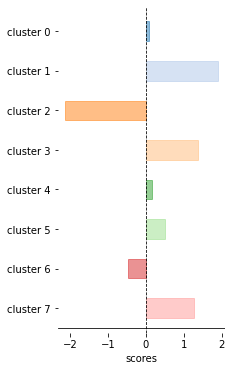

In [102]:
# barplot
temp = pd.read_csv('../processed_data/common_var/rs3755246_cluster_effects.csv')

temp['score'] = np.sign(temp['NES']) * -np.log10(temp['pval'])
temp['cluster'] = ['cluster ' + str(x) for x in temp['pathway']]

plt.figure(figsize=(3,6))
index = np.argsort(-1*temp['pathway'])
temp = temp.loc[index]
#sns.barplot(data=temp, y='cluster', x='score', palette=colors, orient='h', order=temp['cluster'][np.argsort(temp['pathway'])], height=.2)
plt.barh(y=temp['cluster'], width=temp['score'], color=colors[::-1], height=.5, alpha=.5, edgecolor=colors[::-1])
plt.box(False)
plt.axvline(x=0, color='black', linestyle='--', label='Vertical Line',  linewidth=0.8)
plt.axhline(y=-0.5, color='black', linewidth=0.8)
plt.xlabel('scores')
plt.savefig('../pdf_figures/common_var_bar.pdf')

## below is scrap

In [32]:
np.log10(0.05)

-1.3010299956639813

<Axes: xlabel='score', ylabel='cluster'>

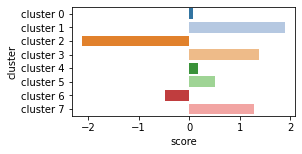

7    cluster 0
1    cluster 1
0    cluster 2
2    cluster 3
6    cluster 4
4    cluster 5
5    cluster 6
3    cluster 7
Name: cluster, dtype: object

['cluster 2',
 'cluster 1',
 'cluster 3',
 'cluster 7',
 'cluster 5',
 'cluster 6',
 'cluster 4',
 'cluster 0']

In [19]:
temp

,Unnamed: 0,pathway,pval,padj,log2err,ES,NES,size,score
0,1,2,0.007539,0.050774,0.274717,-0.521591,-1.666116,31,-2.122684
1,2,1,0.012693,0.050774,0.159153,0.517189,1.585338,38,1.896419
2,3,3,0.040667,0.106093,0.087357,0.456386,1.430772,43,1.390763
3,4,7,0.053047,0.106093,0.076608,0.455928,1.408364,40,1.275342
4,5,5,0.312539,0.451462,0.028688,0.358629,1.099306,38,0.505096
5,6,6,0.338596,0.451462,0.036511,-0.387688,-1.085840,18,-0.470318
6,7,4,0.668592,0.764105,0.017485,0.323588,0.862752,20,0.174839
7,8,0,0.835604,0.835604,0.013323,0.250252,0.767096,38,0.078000


In [ ]:
# show random control above & Holstege 

In [40]:
scores = pd.read_csv('../processed_data/single_cell/all_scores_0825.csv', index_col=0)


In [41]:
unique_clusters = np.unique(frame['cluster'])
cm = plt.cm.get_cmap('tab20')
colors = [cm(int(x)) for x in range(len(unique_clusters))]

/state/partition1/slurm_tmp/24464380.0.0/ipykernel_2659263/599630411.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('tab20')


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a futur

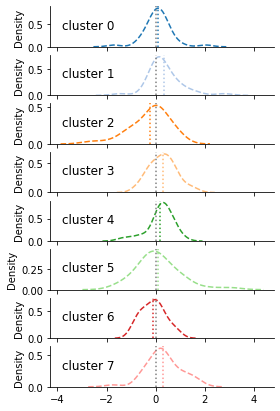

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

In [14]:
# plot score distributions per cluster
frame = pd.read_csv('../supplementary_tables/data_s8.csv')
scores = pd.read_csv('../processed_data/common_var/rs3752246_binary_scores.csv', index_col = 0)
frame = frame[[x in set(scores.index) for x in frame['description']]]

g_names  = np.array(frame['description'][frame['is_gene']])

SCORES = np.array(scores.loc[g_names]['scores'])

temp = [SCORES[frame['cluster'][frame['is_gene']]==i] for i in unique_clusters]
fig, axes = plt.subplots(8, 1, sharex=True, figsize=(4,7))

for i in range(len(temp)):
    plt.figure(figsize = (5,1))

    sns.distplot(temp[i], color=colors[i], kde=True,
        hist=None, label=str(i), ax=axes[i],  kde_kws={'linestyle':'--'});
    l1 = axes[i].lines[0]

    x1 = l1.get_xydata()[:, 0]
    y1 = l1.get_xydata()[:, 1]
    
    axes[i].spines[['right', 'top']].set_visible(False)
    axes[i].set_title('cluster '+str(i), loc='left', y=.3, x=.05)
    axes[i].axvline(np.mean(temp[i]), color=colors[i],linestyle='dotted')
    axes[i].axvline(0, color='grey', linestyle='dotted')
    #axes[i].fill_between(x1, y1, color='grey', alpha=0.3)

/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a futur

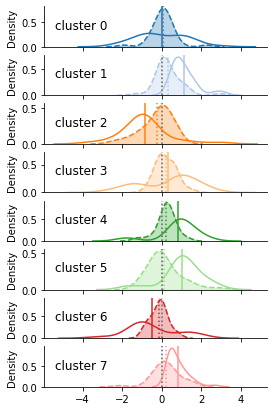

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

In [69]:
# plot score distributions per cluster
frame = pd.read_csv('../supplementary_tables/data_s8.csv')
scores = pd.read_csv('../processed_data/common_var/ex_scores.csv', index_col = 0)
frame = frame[[x in set(scores.index) for x in frame['description']]]

g_names  = np.array(frame['description'][frame['is_gene']])

SCORES = np.array(scores.loc[g_names]['scores'])

temp = [SCORES[frame['cluster'][frame['is_gene']]==i] for i in unique_clusters]
fig, axes = plt.subplots(8, 1, sharex=True, figsize=(4,7))

for i in range(len(temp)):
    plt.figure(figsize = (5,1))

    sns.distplot(temp[i], color=colors[i], kde=True,
        hist=None, label=str(i), ax=axes[i],  kde_kws={'linestyle':'--'});
    l1 = axes[i].lines[0]

    x1 = l1.get_xydata()[:, 0]
    y1 = l1.get_xydata()[:, 1]
    
    axes[i].spines[['right', 'top']].set_visible(False)
    axes[i].set_title('cluster '+str(i), loc='left', y=.3, x=.05)
    axes[i].axvline(np.mean(temp[i]), color=colors[i],linestyle='dotted')
    axes[i].axvline(0, color='grey', linestyle='dotted')
    #axes[i].fill_between(x1, y1, color='grey', alpha=0.3)

# plot score distributions per cluster
frame = pd.read_csv('../supplementary_tables/data_s8.csv')
scores = pd.read_csv('../processed_data/single_cell/all_scores_0825.csv', index_col=0)

g_names  = np.array(frame['description'][frame['is_gene']])

SCORES = np.array(scores.loc[g_names]['Ex'])

temp = [SCORES[frame['cluster'][frame['is_gene']]==i] for i in unique_clusters]

for i in range(len(temp)):
    #plt.figure(figsize = (5,1))

    sns.distplot(temp[i], color=colors[i], kde=True,
        hist=None, label=str(i), ax=axes[i]);
    l1 = axes[i].lines[0]

    x1 = l1.get_xydata()[:, 0]
    y1 = l1.get_xydata()[:, 1]
    
    axes[i].spines[['right', 'top']].set_visible(False)
    axes[i].set_title('cluster '+str(i), loc='left', y=.3, x=.05)
    axes[i].axvline(np.mean(temp[i]), color=colors[i])#, linestyle='dotted')
    axes[i].axvline(0, color='grey', linestyle='dotted')
    axes[i].fill_between(x1, y1, color=colors[i], alpha=0.3)


In [82]:
# plot score distributions per cluster
frame = pd.read_csv('../supplementary_tables/data_s8.csv')
scores = pd.read_csv('../processed_data/common_var/ex_scores.csv', index_col = 0)
frame = frame[[x in set(scores.index) for x in frame['description']]]

g_names  = np.array(frame['description'][frame['is_gene']])

SCORES = np.array(scores.loc[g_names]['scores'])

temp = [SCORES[frame['cluster'][frame['is_gene']]==i] for i in unique_clusters]

,scores,description,Unnamed: 0,cluster,is_gene,grp
0,2.947527,TOP3A,254,1,True,common
1,2.887574,SMC3,238,5,True,common
2,-2.415978,ESRRA,68,2,True,common
3,2.286346,OPRD1,155,0,True,common
4,-2.128037,NDUFA11,131,7,True,common


Text(0.1, 0.5, 'Scores')

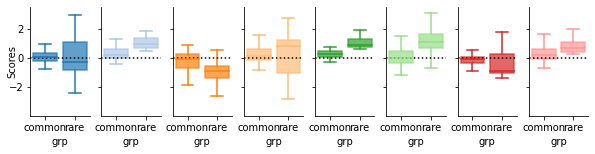

<Figure size 72x360 with 0 Axes>

<Figure size 72x360 with 0 Axes>

<Figure size 72x360 with 0 Axes>

<Figure size 72x360 with 0 Axes>

<Figure size 72x360 with 0 Axes>

<Figure size 72x360 with 0 Axes>

<Figure size 72x360 with 0 Axes>

<Figure size 72x360 with 0 Axes>

In [218]:
fig, axes = plt.subplots(1, 8, sharey=True, figsize=(10,2))

for i in np.unique(TEMP['cluster']):
    plt.figure(figsize = (1,5))
    temp = TEMP[TEMP['cluster']==i]
    boxplot = sns.boxplot(data = temp, x = 'grp', y='scores',color=colors[i], ax=axes[i],             boxprops=dict(alpha=.7,facecolor=colors[i], edgecolor=colors[i]), whiskerprops=dict(color=colors[i]),             medianprops=dict(color=colors[i]),
            capprops=dict(color=colors[i]),             flierprops=dict(markeredgecolor=colors[i], marker='.', markersize=0, markerfacecolor=colors[i], ))



    
    l1 = axes[i].lines[0]

    x1 = l1.get_xydata()[:, 0]
    y1 = l1.get_xydata()[:, 1]
    
    axes[i].spines[['right', 'top']].set_visible(False)
    #axes[i].set_title('cluster '+str(i), loc='left', y=.3, x=.05)
    #axes[i].axvline(np.mean(temp[i]), color=colors[i])#, linestyle='dotted')
    axes[i].axhline(0, color='black', linestyle='dotted')
    axes[i].fill_between(x1, y1, color=colors[i], alpha=0.3)
    axes[i].set_ylabel('')
# Add common title for the y-axis
fig.text(0.1, 0.5, 'Scores', ha='center', va='center', rotation='vertical')


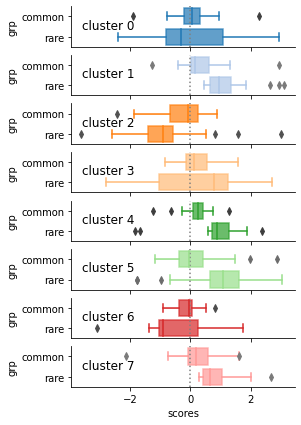

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

In [186]:
fig, axes = plt.subplots(8, 1, sharex=True, figsize=(4,7))

for i in np.unique(TEMP['cluster']):
    plt.figure(figsize = (5,1))
    temp = TEMP[TEMP['cluster']==i]
    boxplot = sns.boxplot(data = temp, y = 'grp', x='scores',color=colors[i], ax=axes[i],             boxprops=dict(alpha=.7,facecolor=colors[i], edgecolor=colors[i]), whiskerprops=dict(color=colors[i]),             medianprops=dict(color=colors[i]),
            capprops=dict(color=colors[i]))



    
    l1 = axes[i].lines[0]

    x1 = l1.get_xydata()[:, 0]
    y1 = l1.get_xydata()[:, 1]
    
    axes[i].spines[['right', 'top']].set_visible(False)
    axes[i].set_title('cluster '+str(i), loc='left', y=.3, x=.05)
    #axes[i].axvline(np.mean(temp[i]), color=colors[i])#, linestyle='dotted')
    axes[i].axvline(0, color='grey', linestyle='dotted')
    axes[i].fill_between(x1, y1, color=colors[i], alpha=0.3)


In [165]:
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0),
 (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 (1.0, 0.7333333333333333, 0.47058823529411764, 1.0),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353, 1.0),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
 (1.0, 0.596078431372549, 0.5882352941176471, 1.0)]

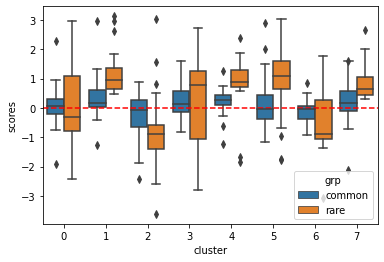

In [159]:
sns.boxplot(data=TEMP, x='cluster', y='scores', hue = 'grp')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')


In [129]:
scores = pd.read_csv('../processed_data/single_cell/all_scores_0825.csv', index_col=0)
scores = pd.DataFrame(scores['Ex'])

In [132]:
scores.colnames = 'test'

In [133]:
scores

,Ex
DTNBP1,-0.126932
VRK2,0.000000
ZBED5,2.611961
TMED3,1.281436
SEMA6B,0.077767
...,...
RNF152,0.000000
CYGB,0.000000
PNOC,0.000000
TMEM182,0.000000


In [116]:
temp2

,Ex,description,Unnamed: 0,cluster,is_gene,grp
0,2.326606,CDC7,40,5,True,rare
1,1.390363,PSMD11,188,3,True,rare
2,1.551225,MSH6,121,4,True,rare
3,1.584546,BARD1,25,1,True,rare
4,0.639716,WRN,267,1,True,rare
...,...,...,...,...,...,...
263,-1.553847,NR1H3,153,2,True,rare
264,-1.720019,RARA,202,2,True,rare
265,-1.781328,MAT2B,114,5,True,rare
266,-2.407135,CCKBR,38,0,True,rare


In [112]:
scores

,Ex
DTNBP1,-0.126932
VRK2,0.000000
ZBED5,2.611961
TMED3,1.281436
SEMA6B,0.077767
...,...
RNF152,0.000000
CYGB,0.000000
PNOC,0.000000
TMEM182,0.000000


,scores,description,Unnamed: 0,cluster,is_gene,grp
0,2.947527,TOP3A,254,1,True,common
1,2.887574,SMC3,238,5,True,common
2,-2.415978,ESRRA,68,2,True,common
3,2.286346,OPRD1,155,0,True,common
4,-2.128037,NDUFA11,131,7,True,common
...,...,...,...,...,...,...
261,0.007525,TOPBP1,255,1,True,common
262,-0.006909,ATRX,23,1,True,common
263,-0.005225,BID,28,6,True,common
264,0.003087,MSH6,121,4,True,common


In [99]:
temp

,scores,description,Unnamed: 0,cluster,is_gene,grp
0,2.947527,TOP3A,254,1,True,common
1,2.887574,SMC3,238,5,True,common
2,-2.415978,ESRRA,68,2,True,common
3,2.286346,OPRD1,155,0,True,common
4,-2.128037,NDUFA11,131,7,True,common
...,...,...,...,...,...,...
261,0.007525,TOPBP1,255,1,True,common
262,-0.006909,ATRX,23,1,True,common
263,-0.005225,BID,28,6,True,common
264,0.003087,MSH6,121,4,True,common


In [91]:
pd.merge

<function pandas.core.reshape.merge.merge(left: 'DataFrame | Series', right: 'DataFrame | Series', how: 'str' = 'inner', on: 'IndexLabel | None' = None, left_on: 'IndexLabel | None' = None, right_on: 'IndexLabel | None' = None, left_index: 'bool' = False, right_index: 'bool' = False, sort: 'bool' = False, suffixes: 'Suffixes' = ('_x', '_y'), copy: 'bool' = True, indicator: 'bool' = False, validate: 'str | None' = None) -> 'DataFrame'>

/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments witho

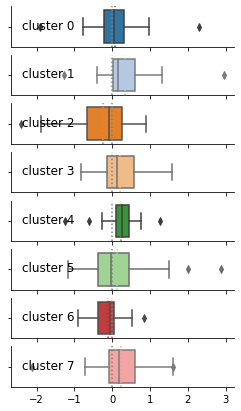

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

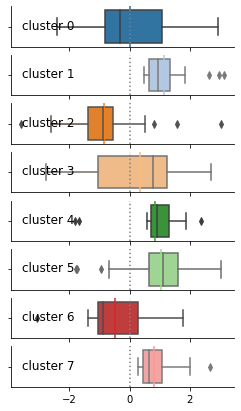

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

In [81]:
# plot score distributions per cluster
frame = pd.read_csv('../supplementary_tables/data_s8.csv')
scores = pd.read_csv('../processed_data/common_var/ex_scores.csv', index_col = 0)
frame = frame[[x in set(scores.index) for x in frame['description']]]

g_names  = np.array(frame['description'][frame['is_gene']])

SCORES = np.array(scores.loc[g_names]['scores'])

temp = [SCORES[frame['cluster'][frame['is_gene']]==i] for i in unique_clusters]
fig, axes = plt.subplots(8, 1, sharex=True, figsize=(4,7))

for i in range(len(temp)):
    plt.figure(figsize = (5,1))

    sns.boxplot(temp[i], color=colors[i], ax=axes[i])
    l1 = axes[i].lines[0]

    x1 = l1.get_xydata()[:, 0]
    y1 = l1.get_xydata()[:, 1]
    
    axes[i].spines[['right', 'top']].set_visible(False)
    axes[i].set_title('cluster '+str(i), loc='left', y=.3, x=.05)
    axes[i].axvline(np.mean(temp[i]), color=colors[i],linestyle='dotted')
    axes[i].axvline(0, color='grey', linestyle='dotted')
    #axes[i].fill_between(x1, y1, color='grey', alpha=0.3)

# plot score distributions per cluster
frame = pd.read_csv('../supplementary_tables/data_s8.csv')
scores = pd.read_csv('../processed_data/single_cell/all_scores_0825.csv', index_col=0)

g_names  = np.array(frame['description'][frame['is_gene']])

SCORES = np.array(scores.loc[g_names]['Ex'])

temp = [SCORES[frame['cluster'][frame['is_gene']]==i] for i in unique_clusters]
fig, axes = plt.subplots(8, 1, sharex=True, figsize=(4,7))

for i in range(len(temp)):
    plt.figure(figsize = (5,1))

    sns.boxplot(temp[i], color=colors[i], ax=axes[i])
    l1 = axes[i].lines[0]

    x1 = l1.get_xydata()[:, 0]
    y1 = l1.get_xydata()[:, 1]
    
    axes[i].spines[['right', 'top']].set_visible(False)
    axes[i].set_title('cluster '+str(i), loc='left', y=.3, x=.05)
    axes[i].axvline(np.mean(temp[i]), color=colors[i])#, linestyle='dotted')
    axes[i].axvline(0, color='grey', linestyle='dotted')
    axes[i].fill_between(x1, y1, color=colors[i], alpha=0.3)


In [ ]:

# plot score distributions per cluster
frame = pd.read_csv('../supplementary_tables/data_s8.csv')
scores = pd.read_csv('../processed_data/single_cell/all_scores_0825.csv', index_col=0)

g_names  = np.array(frame['description'][frame['is_gene']])

SCORES = np.array(scores.loc[g_names]['Ex'])

temp = [SCORES[frame['cluster'][frame['is_gene']]==i] for i in unique_clusters]

for i in range(len(temp)):
    #plt.figure(figsize = (5,1))

    sns.distplot(temp[i], color=colors[i], kde=True,
        hist=None, label=str(i), ax=axes[i]);
    l1 = axes[i].lines[0]

    x1 = l1.get_xydata()[:, 0]
    y1 = l1.get_xydata()[:, 1]
    
    axes[i].spines[['right', 'top']].set_visible(False)
    axes[i].set_title('cluster '+str(i), loc='left', y=.3, x=.05)
    axes[i].axvline(np.mean(temp[i]), color=colors[i])#, linestyle='dotted')
    axes[i].axvline(0, color='grey', linestyle='dotted')
    axes[i].fill_between(x1, y1, color=colors[i], alpha=0.3)
